# SNIa likelihood DEMO

This notebook shows an example of how to use and combine the likelihoods available.

**Warning:** in order to use this notebook you need to download the Pantheon+ data from **_Insert link to data here_**

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sb

from copy      import deepcopy
from itertools import product
from bios      import read
from tqdm      import tqdm

from cobaya.model import get_model

from theory_code.distance_theory import TheoryCalcs

#Plotting
import matplotlib
import matplotlib.pyplot as plt

from matplotlib import rc

rc('text', usetex=True)
rc('font', family='serif')
matplotlib.rcParams.update({'font.size': 18})

red    = '#8e001c'
yellow = '#ffb302'

sidelegend = {'bbox_to_anchor': (1.04,0.5), 
              'loc': "center left",
              'frameon': False}
bottomlegend = {'bbox_to_anchor': (0.35,-0.2), 
                'loc': "center left",
                'frameon': False,
                'ncols': 3}

# Fiducial and testing options

We fix here some of the settings used to visualize the results of the likelihood model

- fiducial: value of the cosmological parameter
- varpar: parameter over which to run the likelihood

In [2]:
fiducial = {'omegam': 0.334,
            'H0': 73.6,
            'w': -1.,
            'ombh2': 0.02218,
            'MB': -19.2435}

varpar = {'name': 'omegam',
          'latex': r'$\Omega_{\rm m}$',
          'min': 0.01,
          'max': 0.99, 
          'N': 100}

# Run options

Here we see the different options that need to be set to make the likelihood function.

We see them here as separate, but when running a full sampling, these are handled all together by the `runner.py` script.

In [3]:
info = {}

## Likelihood settings

Here we list the settings required by the SNIa likelihood:

- `path`: the path to the SN dataset to be used
- `use_Pantheon`: if True, the code looks for a data and a coviariance file, in the format of the Pantheon+ data. If set to False, the code looks for a data file with columns z and mB and for a covariance matrix
- `calibration`: decides how to deal with the $M_B-H_0$ degeneracy. Options are: `SH0ES` to use the Cepheids distance ladder, `Marginalized` to use the analytical marginalization over $M_B$ and $H_0$, `None` to not use any calibration (one can still set a Gaussian prior over $M_B$, see the sampling part at the bottom of this notebook)

For the moment, we will use Pantheon+ data with the SH0ES calibration, but we will later compare the different approaches

In [4]:
from likelihood.handler import LikelihoodHandler

like = {'SN_data': {'path': 'data/Pantheon',
                    'use_Pantheon': True,
                    'calibration': 'SH0ES'}}

LikeSets = LikelihoodHandler(like)
info['likelihood'] = LikeSets.like_dict
print(info['likelihood'])


LOADING SN DATA

{'calibration': 'SH0ES', 'path': 'data/Pantheon', 'use_Pantheon': True}
Using SH0ES calibration
{'SNlike': {'external': <class 'likelihood.SN_likelihood.SNLike'>, 'SN_data_path': 'data/Pantheon', 'use_Pantheon': True, 'calibration': 'SH0ES'}}


## Theory settings

In order to work, the likelihood needs

In [5]:
from theory_code.handler import TheoryHandler

theory = {'cosmology': 'Standard',
          'fiducial_path': None,
          'DDR_options': None}

info['theory'] = TheoryHandler(theory).theory_dict

## Parameter settings

When launching the likelihood, we need to know which parameters are free to vary and which we are fixed. We load this information from one of the default settings files, a $w$CDM parameterization

In [6]:
preinfo = read('settings/standard/Pantheon_wCDM.yaml')

info['params'] = preinfo['params']
print(info['params'])

{'omegam': {'latex': '\\Omega_\\mathrm{m}', 'prior': {'min': 0.001, 'max': 0.99}, 'proposal': 0.05, 'ref': {'dist': 'norm', 'loc': 0.3, 'scale': 0.01}, 'drop': True}, 'omch2': {'value': 'lambda omegam, ombh2, omnuh2, H0: omegam*(H0/100)**2-ombh2-omnuh2', 'latex': '\\Omega_\\mathrm{c} h^2'}, 'ombh2': {'latex': '\\Omega_\\mathrm{b} h^2', 'prior': {'dist': 'norm', 'loc': 0.02218, 'scale': 0.00055}, 'proposal': 0.0001, 'ref': {'dist': 'norm', 'loc': 0.0222, 'scale': 0.0001}}, 'H0': {'latex': 'H_0', 'prior': {'max': 100.0, 'min': 20.0}, 'proposal': 0.5, 'ref': {'dist': 'norm', 'loc': 67.0, 'scale': 0.5}}, 'MB': {'latex': 'M_B', 'proposal': 0.01, 'ref': {'dist': 'norm', 'loc': -19.2435, 'scale': 0.01}, 'prior': {'min': -22.0, 'max': -15.0}}, 'omk': 0.0, 'w': {'latex': 'w_0', 'proposal': 0.05, 'ref': {'dist': 'norm', 'loc': -1.0, 'scale': 0.01}, 'prior': {'min': -3.0, 'max': -0.5}}, 'wa': 0.0, 'omnuh2': 0.0006442, 'nnu': 3, 'rdrag': {'latex': 'r_\\mathrm{d}', 'derived': True}, 'omegaL': {'lat

# Exploring the likelihood

We exploit the Cobaya class `get_model` to access the calculations of the likelihood module.

This is not the pipeline used when doing actual runs, but it allows us to look at the different parts of the likelihood

In [7]:
model = get_model(info)

Using calibrated Pantheon data
Loading covariance from data/Pantheon_covmat.txt
Done


With the get_model instruction applied, we can now access information concerning the likelihood and the running settings, e.g. the sets of free or derived parameters

In [8]:
free_params    = model.parameterization.sampled_params()
derived_params = model.parameterization.derived_params()
print('Free: ',free_params)
print('Derived: ',derived_params)

Free:  {'omegam': nan, 'ombh2': nan, 'H0': nan, 'MB': nan, 'w': nan}
Derived:  {'omch2': nan, 'rdrag': nan, 'omegaL': nan}


## Fiducial calculations

We can make the code run end-to-end at a specific point, e.g. the fiducial, to compute the value of the posterior and even accessing the theoretical calculations for that point

In [9]:
logpost_fid = model.logposterior(fiducial)
print(logpost_fid)

LogPosterior(logpost=-731.5871628413787, logpriors=[-0.6465128217108402], loglikes=array([-730.94065002]), derived=[0.158102264, 138.47596278160105, 0.665933763593399], finite=False)


## Visualize data and theory

We can retrieve both the data and the theory used in the calculations

In [10]:
dataset = model.likelihood['SNlike'].dataset_SN
covmat  = np.linalg.inv(model.likelihood['SNlike'].invcovmat)

dataset['err'] = np.sqrt(np.diag(covmat))

print(dataset)

            z     zHEL        mB       err
0     0.00122  0.00082   9.74571  0.178244
1     0.00122  0.00082   9.80286  0.185921
2     0.00256  0.00144  11.47030  0.247502
3     0.00256  0.00144  11.49190  0.276550
5     0.00317  0.00236  11.54160  0.155967
...       ...      ...       ...       ...
1696  1.61505  1.61399  25.90650  0.241135
1697  1.69706  1.70000  26.03330  0.270997
1698  1.80119  1.80000  26.23350  0.203896
1699  1.91165  1.91401  26.17030  0.259669
1700  2.26137  2.26000  26.92980  0.212109

[1657 rows x 4 columns]


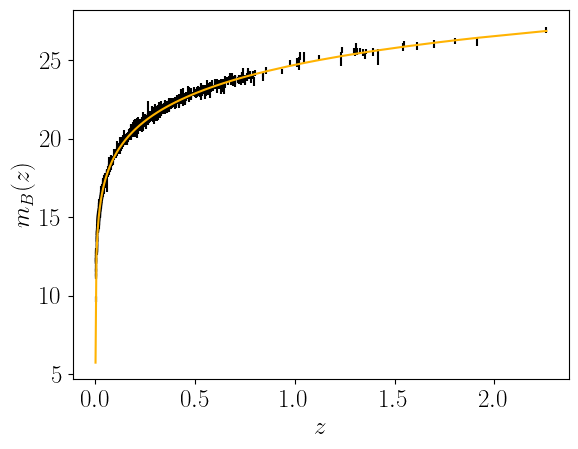

In [11]:
plt.figure()
plt.errorbar(dataset['z'],dataset['mB'],yerr=dataset['err'],color='black',ls='')
plt.plot(dataset['z'],model.provider.get_result('mB')(dataset['z']),color=yellow)
plt.xlabel(r'$z$')
plt.ylabel(r'$m_B(z)$');

## Computing the posterior on a grid

As a quick check, we can sample the posterior over a grid for a single parameter (the varpar variable chosen at the beginning), while keeping all others fixed at their fiducial values.

In [12]:
par_vals = np.linspace(varpar['min'],varpar['max'],varpar['N'])

chi2s = [pd.DataFrame({varpar['name']: fiducial[varpar['name']],
                       'chi2': -2*logpost_fid.logpost},index=[0])]
for val in tqdm(par_vals):
    varpoint = deepcopy(fiducial)
    varpoint[varpar['name']] = val
    logpost = model.logposterior(varpoint)
    chi2s.append(pd.DataFrame({varpar['name']: val,
                               'chi2': -2*logpost.logpost},index=[0]))

chi2 = pd.concat(chi2s,ignore_index=True)


00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.70it/s]

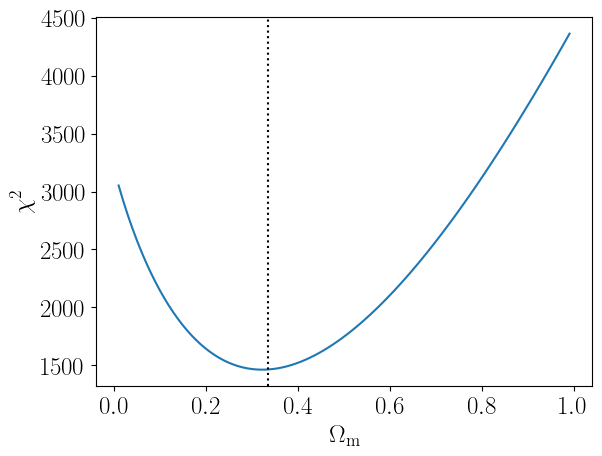

In [13]:
plt.figure()
sb.lineplot(chi2,x=varpar['name'],y='chi2')
plt.axvline(x=fiducial[varpar['name']],ls=':',color='black')
plt.xlabel(varpar['latex'])
plt.ylabel(r'$\chi^2$');

# Sampling the posterior

Up to this point, we gave the code no instructions on how to sample the parameter space and reconstruct the posterior, except for when we computed it on a grid.

Below, we see how the sampling work, also making some example on the usage of the SN calibration option.

**WARNING: running this part of the notebook might require some time**

## Sampling settings

This code has a working interface with Cobaya, and therefore it can use all the samplers available for that code. In addition to this, it is also possible to use nested sampling through the Nautilus sampler.

The code requires information on the sampler to be provided with a dictionary with entries:
- `name`: specifying the sampler to be used (`mcmc`, `minimize`, `evaluate`, `nautilus`). The first three coincide with the samplers used by Cobaya, while the latter allows to switch to Nautilus;
- `options`: a dictionary containing the options suitable for the chosen sampler. Notice that, in case Nautilus is chosen, two sets of options are easily available in the code. Choosing `option`: `poor` runs Nautilus with options suitable for a quick test, while `options`: `good` runs it with more precise settings

In [14]:
from samplers.handler import SamplingHandler

### Example 1: minimization

With these settings, the code searches for the peak of the posterior using Cobaya

In [15]:
sampinfo = {'sampler': {'name': 'minimize',
                        'options': None}}

sampler = SamplingHandler(sampinfo)
info['sampler'] = sampler.sampling_dictionary

Running with Metropolis-Hastings


In [16]:
updated_info,minimum = sampler.run(info)

Using calibrated Pantheon data
Loading covariance from data/Pantheon_covmat.txt
Done
[minimize] Initializing
[minimize] Run 1/2 will start from random initial point:
[minimize] {'omegam': 0.31284061864348894, 'ombh2': 0.02212789611305377, 'H0': 67.74605070808626, 'MB': -19.242520826258033, 'w': -1.008350580635112}
[minimize] Run 2/2 will start from random initial point:
[minimize] {'omegam': 0.2928461978273476, 'ombh2': 0.02207624076292437, 'H0': 67.40936347130615, 'MB': -19.22303194278573, 'w': -0.9868810167769227}
[prior] *WARNING* There are unbounded parameters (['ombh2']). Prior bounds are given at 0.9999995 confidence level. Beware of likelihood modes at the edge of the prior
[minimize] Starting run 1/2
[minimize] Run 1/2 converged.
[minimize] Starting run 2/2
[minimize] Run 2/2 converged.
[minimize] Finished successfully!
[minimize] *WARNING* Modest spread in minima: [730.9308711868366, 730.4542987371897]
[minimize] -log(posterior) minimized to 730.454
[minimize] Parameter values

### Example 2: nested sampling

with these settings we reconstruct the posterior

In [17]:
sampinfo = {'sampler': {'name': 'nautilus',
                        'options': 'poor'}}

sampler = SamplingHandler(sampinfo)
info['sampler'] = sampler.sampling_dictionary

Running with Nautilus


In [18]:
chain,nautilus_dict = sampler.run(info)


RUNNING WITH NAUTILUS SAMPLER

Loading model wrapper of Cobaya
[model] *WARNING* Ignored blocks/options: ['sampler']
Using calibrated Pantheon data
Loading covariance from data/Pantheon_covmat.txt
Done
model loaded
Preparing the prior...
Loaded prior into Nautilus with dimension 5
Prior keys:  ['omegam', 'ombh2', 'H0', 'MB', 'w']
Starting to sample with Nautilus...
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 27     | 1        | 2        | 20480    | N/A    | 10048 | -744.50  
NAUTILUS SAMPLING FINISHED


### Plotting

Below a simple function to analyze the output of the tests above. A more sophisticated class to analyze data is available, still linked to getdist, but for a description of that see **_ADD DEMO PLOTTING_**

In [19]:
from getdist import MCSamples,plots

def get_sample(chain,params):

    sample = MCSamples(samples=chain[list(params.keys())].values,names=list(params.keys()),labels=list(params.values()))
    
    return sample

In [20]:
sh0es_sample = get_sample(chain,nautilus_dict)

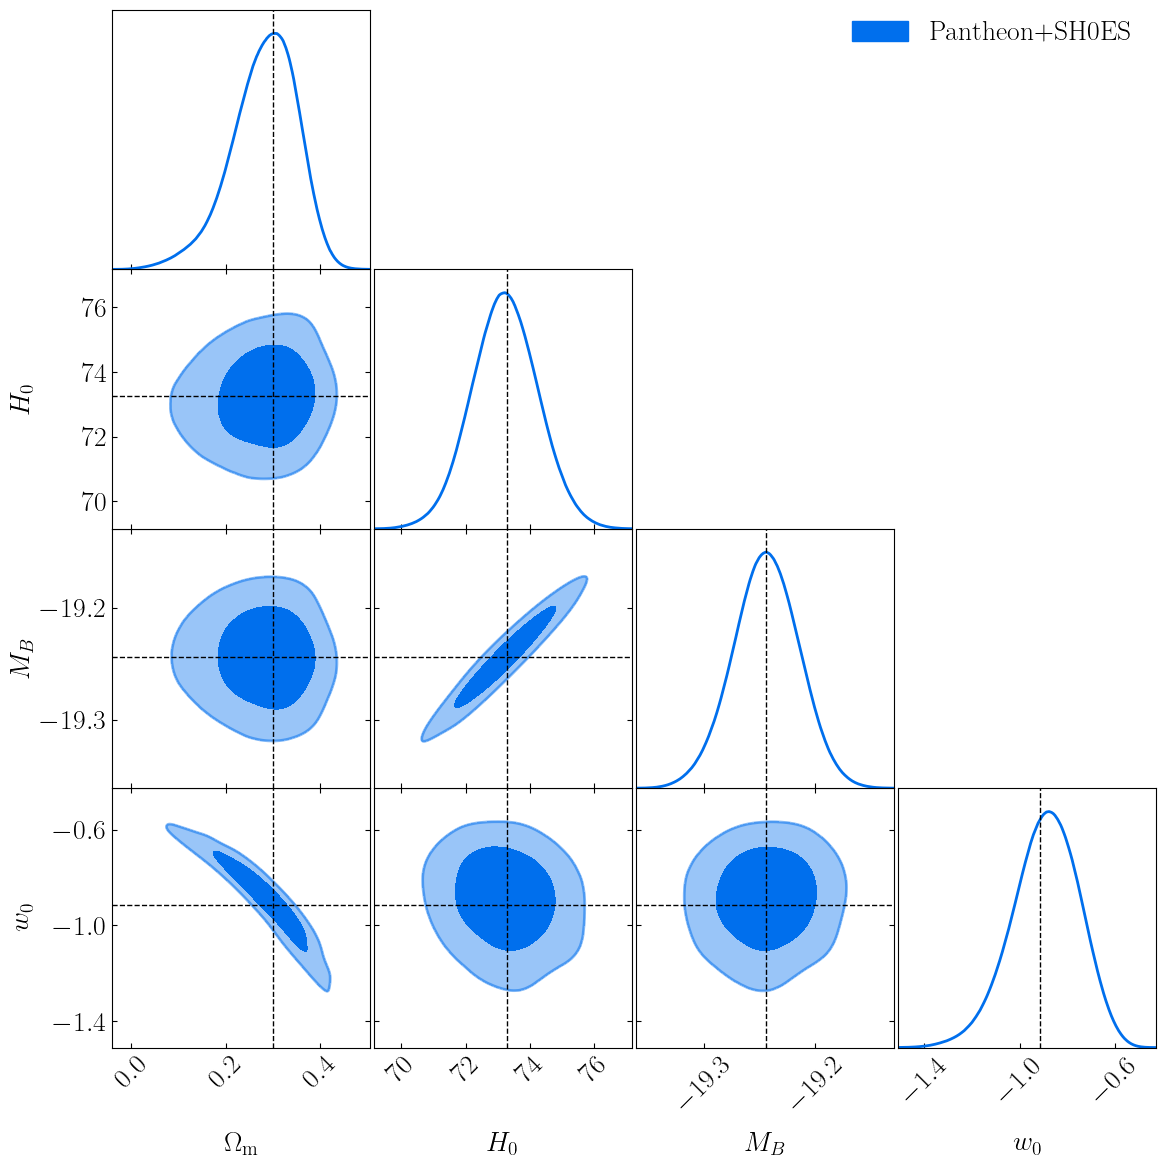

In [21]:
params = ['omegam','H0','MB','w']

g = plots.get_subplot_plotter(subplot_size=1,width_inch=12, scaling=False)
g.settings.figure_legend_frame = False
g.settings.axes_fontsize=20
g.settings.axes_labelsize=20
g.settings.legend_fontsize=20
g.settings.axis_marker_color = 'black'
g.settings.axis_marker_ls = '--'
g.settings.axis_marker_lw = 1
g.settings.axis_tick_x_rotation = 45
g.triangle_plot([sh0es_sample], params,
    filled=True,
    legend_loc='upper right',
    legend_labels=['Pantheon+SH0ES'],
    contour_lws=2,
    markers={par: minimum.minimum[par] for par in params})
g.fig.align_ylabels()
g.fig.align_xlabels();

## Comparing SNIa Likelihood Options

The Supernova (SN) likelihood can be configured in different ways.  


### Data options

Currently, both **Pantheon** (to be revised) and **Pantheon+** data are supported.  You can switch datasets with:  

`use_Pantheon = True`

This option loads the original Pantheon data together with its covariance matrix. 

If you are not using **Pantheon** or **Pantheon+** fix `use_Pantheon = False`.



### Calibration options for $H_0$ and $M_B$

The treatment of the Hubble constant ($H_0$) and the absolute magnitude ($M_B$) is controlled by the `calibration` flag:

- `calibration = SH0ES`  
  Use the SH0ES calibration of $M_B$ directly in the likelihood, as in Riess et al. (ref).  

- `calibration = Marginalized`  
  Marginalize over both $H_0$ and $M_B$, so the likelihood does **not constrain** these parameters.  

- `calibration = None`  
  Behavior depends on the prior assigned to $M_B$:  
  - With a **Gaussian prior**, the prior is applied (equivalent to the SH0ES calibration).  
  - With a **flat prior** or a **fixed value**, no calibration is applied (equivalent to the Marginalization).



### SH0ES calibration

In [22]:
cases = {'SH0ES calibration': {'sample': sh0es_sample,
                               'color': 'blue',
                               'filled': True}}

### Analytical marginalization

In [23]:
marg_info = deepcopy(info)

like = {'SN_data': {'path': 'data/Pantheon',
                    'use_Pantheon': True,
                    'calibration': 'Marginalized'}}

LikeSets = LikelihoodHandler(like)
marg_info['likelihood'] = LikeSets.like_dict

chain,nautilus_dict = sampler.run(marg_info)


LOADING SN DATA

{'calibration': 'Marginalized', 'path': 'data/Pantheon', 'use_Pantheon': True}

Using the SN likelihood analytically marginalized for H0 and MB.
WARNING! If you have these parameters free to vary, you will get no information coming from SN


RUNNING WITH NAUTILUS SAMPLER

Loading model wrapper of Cobaya
[model] *WARNING* Ignored blocks/options: ['sampler']
Using mB with free MB
Loading covariance from data/Pantheon_covmat.txt
Done
model loaded
Preparing the prior...
Loaded prior into Nautilus with dimension 5
Prior keys:  ['omegam', 'ombh2', 'H0', 'MB', 'w']
Starting to sample with Nautilus...
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 20     | 2        | 2        | 60672    | N/A    | 10002 | -715.68  
NAUTILUS SAMPLING FINISHED


In [24]:
cases['Analytical marginalization'] = {'sample': get_sample(chain,nautilus_dict),
                                       'color': red,
                                       'filled': False}

### Gaussian prior over $M_B$

In [25]:
gauss_info = deepcopy(info)

like = {'SN_data': {'path': 'data/Pantheon',
                    'use_Pantheon': True,
                    'calibration': None}}

LikeSets = LikelihoodHandler(like)
gauss_info['likelihood'] = LikeSets.like_dict

gauss_info['params']['MB']['prior'] = {'dist': 'norm', 'loc': -19.2435, 'scale': 0.0373}

chain,nautilus_dict = sampler.run(gauss_info)


LOADING SN DATA

{'calibration': None, 'path': 'data/Pantheon', 'use_Pantheon': True}


RUNNING WITH NAUTILUS SAMPLER

Loading model wrapper of Cobaya
[model] *WARNING* Ignored blocks/options: ['sampler']
Using mB with free MB
Loading covariance from data/Pantheon_covmat.txt
Done
model loaded
Preparing the prior...
Loaded prior into Nautilus with dimension 5
Prior keys:  ['omegam', 'ombh2', 'H0', 'MB', 'w']
Starting to sample with Nautilus...
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 20     | 1        | 2        | 21312    | N/A    | 10018 | -714.58  
NAUTILUS SAMPLING FINISHED


In [26]:
cases[r'Gaussian $M_B$'] = {'sample': get_sample(chain,nautilus_dict),
                            'color': 'black',
                            'filled': False}

### No calibration and no prior

In [27]:
flat_info = deepcopy(info)

like = {'SN_data': {'path': 'data/Pantheon',
                    'use_Pantheon': True,
                    'calibration': None}}

LikeSets = LikelihoodHandler(like)
flat_info['likelihood'] = LikeSets.like_dict

chain,nautilus_dict = sampler.run(flat_info)


LOADING SN DATA

{'calibration': None, 'path': 'data/Pantheon', 'use_Pantheon': True}


RUNNING WITH NAUTILUS SAMPLER

Loading model wrapper of Cobaya
[model] *WARNING* Ignored blocks/options: ['sampler']
Using mB with free MB
Loading covariance from data/Pantheon_covmat.txt
Done
model loaded
Preparing the prior...
Loaded prior into Nautilus with dimension 5
Prior keys:  ['omegam', 'ombh2', 'H0', 'MB', 'w']
Starting to sample with Nautilus...
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 20     | 3        | 2        | 84672    | N/A    | 10007 | -715.62  
NAUTILUS SAMPLING FINISHED


In [28]:
cases['No calibration'] = {'sample': get_sample(chain,nautilus_dict),
                           'color': yellow,
                           'filled': False}

### Plotting comparison

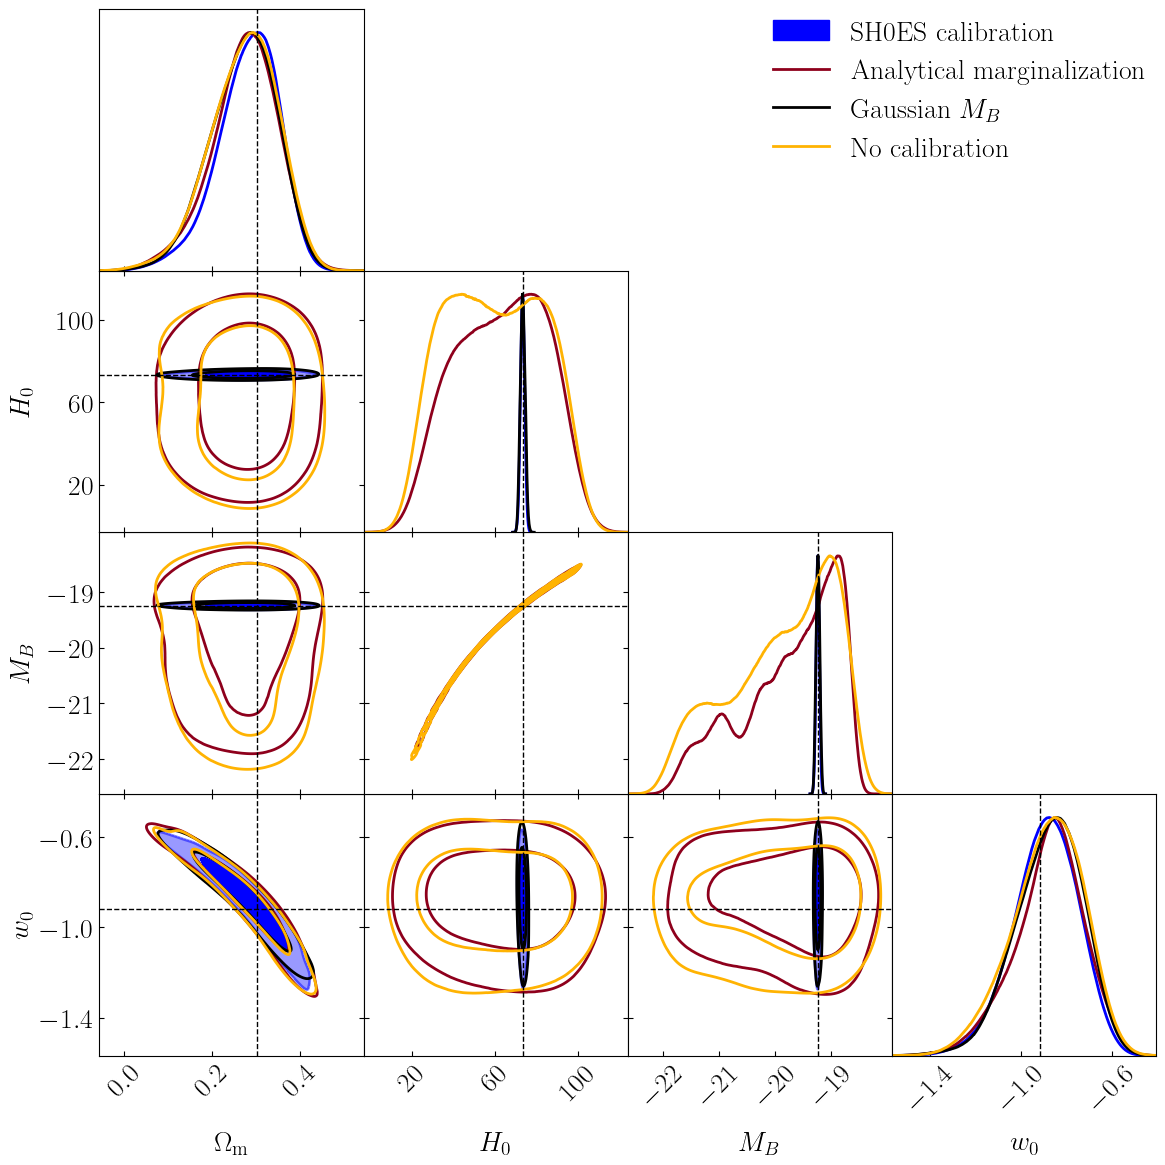

In [29]:
params = ['omegam','H0','MB','w']

g = plots.get_subplot_plotter(subplot_size=1,width_inch=12, scaling=False)
g.settings.figure_legend_frame = False
g.settings.axes_fontsize=20
g.settings.axes_labelsize=20
g.settings.legend_fontsize=20
g.settings.axis_marker_color = 'black'
g.settings.axis_marker_ls = '--'
g.settings.axis_marker_lw = 1
g.settings.axis_tick_x_rotation = 45
g.triangle_plot([case['sample'] for case in cases.values()], params,
    filled=[case['filled'] for case in cases.values()],
    legend_loc='upper right',
    legend_labels=[case for case in cases.keys()],
    contour_colors=[case['color'] for case in cases.values()],
    contour_lws=2,
    markers={par: minimum.minimum[par] for par in params})
g.fig.align_ylabels()
g.fig.align_xlabels();

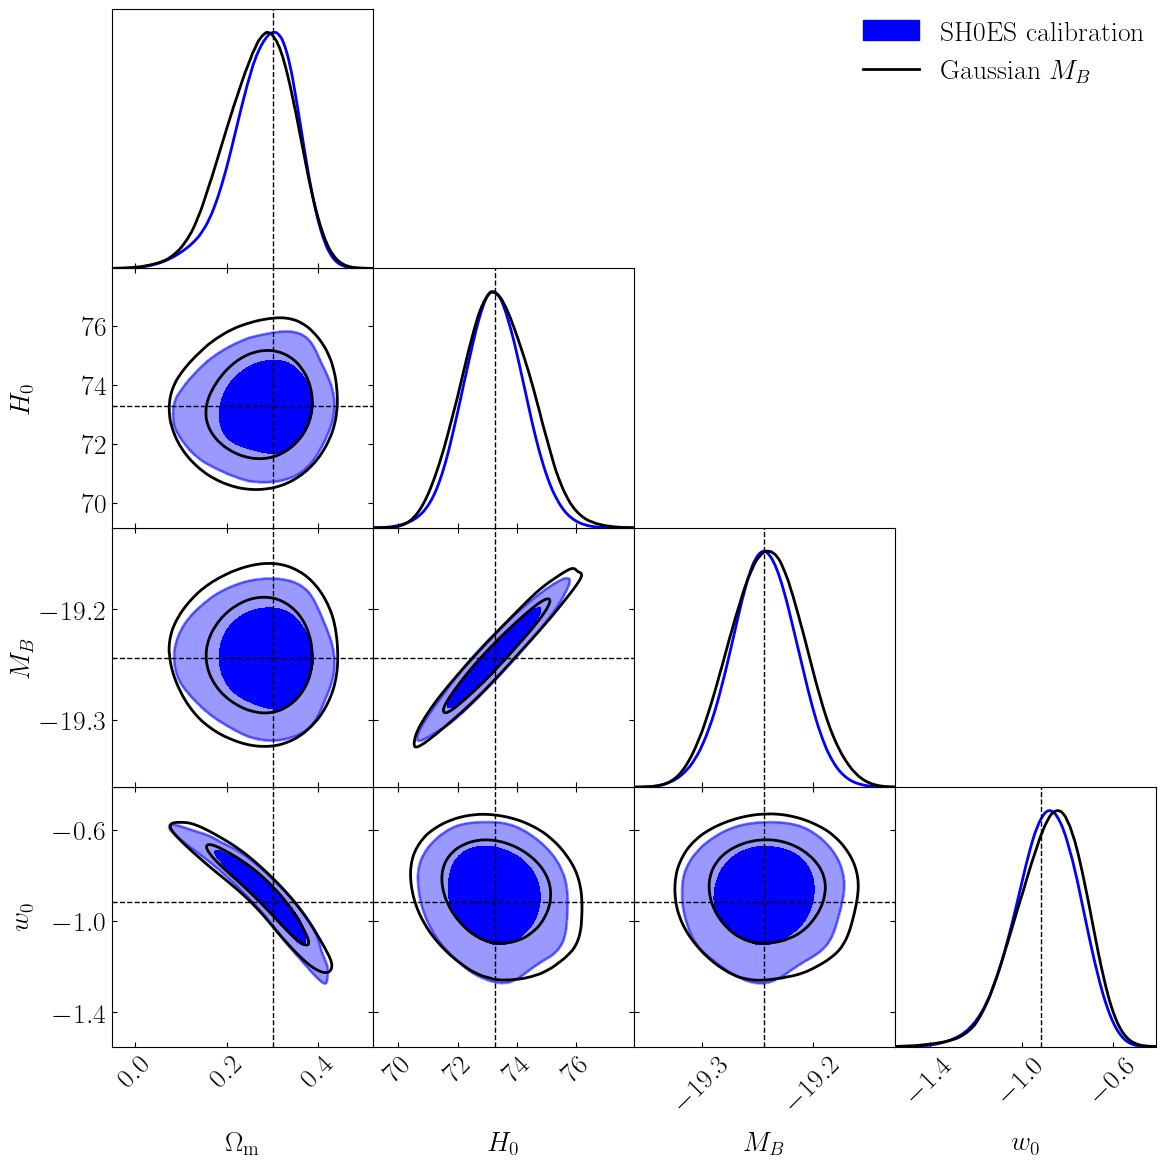

In [31]:
params = ['omegam','H0','MB','w']

calibrated = {name: case for name,case in cases.items() if name in ['SH0ES calibration',r'Gaussian $M_B$']}

g = plots.get_subplot_plotter(subplot_size=1,width_inch=12, scaling=False)
g.settings.figure_legend_frame = False
g.settings.axes_fontsize=20
g.settings.axes_labelsize=20
g.settings.legend_fontsize=20
g.settings.axis_marker_color = 'black'
g.settings.axis_marker_ls = '--'
g.settings.axis_marker_lw = 1
g.settings.axis_tick_x_rotation = 45
g.triangle_plot([case['sample'] for case in calibrated.values()], params,
    filled=[case['filled'] for case in calibrated.values()],
    legend_loc='upper right',
    legend_labels=[case for case in calibrated.keys()],
    contour_colors=[case['color'] for case in calibrated.values()],
    contour_lws=2,
    markers={par: minimum.minimum[par] for par in params})
g.fig.align_ylabels()
g.fig.align_xlabels();